In [ ]:
#| default_exp inverse_design_local_generator

In [2]:
#| exporti

from inverse_design.inverse_design import *
from inverse_design.brushes import notched_square_brush
from inverse_design.naive_inverse_design import (
    viz_sim, mode_overlap, mask_combine_epsr, init_domain
)
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange
from jax.example_libraries.optimizers import adam
from ceviche.modes import insert_mode

In [3]:
#| exporti

import jax
import jax.numpy as jnp
from javiche import jaxit
import matplotlib.pylab as plt
import numpy as np
from inverse_design.local_generator import generate_feasible_design_mask


# Global flag to set a specific platform, must be used at startup.
jax.config.update('jax_platform_name', 'cpu')

> This notebook overwrites the inverse design notebook to use the local_generator

In [4]:
# Angular frequency of the source in Hz
omega = 2 * np.pi * 200e12
# Spatial resolution in meters
dl = 30e-9
# Number of pixels in x-direction
Nx = 120
# Number of pixels in y-direction
Ny = 120
# Number of pixels in the PMLs in each direction
Npml = 20
# Initial value of the structure's relative permittivity
epsr_init = 12.0
# Space between the PMLs and the design region (in pixels)
space = 10
# Width of the waveguide (in pixels)
wg_width = 12
# Length in pixels of the source/probe slices on each side of the center point
space_slice = 8
# Number of epochs in the optimization
Nsteps = 150
# Step size for the Adam optimizer
def step_size(idx):
  """reducing the stepsize linearly for Nsteps (stabilize afterwards just in case)"""
  return np.maximum((5e-3)**(idx/Nsteps), 5e-3)

In [5]:
epsr, bg_epsr, design_region, input_slice, output_slice = init_domain(
    Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice
)

In [6]:
epsr_total = mask_combine_epsr(epsr, bg_epsr, design_region)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_total, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_total, m=2)

## Prepare

In [7]:
brush = notched_square_brush(5, 1)
latent = new_latent_design((Nx, Ny), r=1)

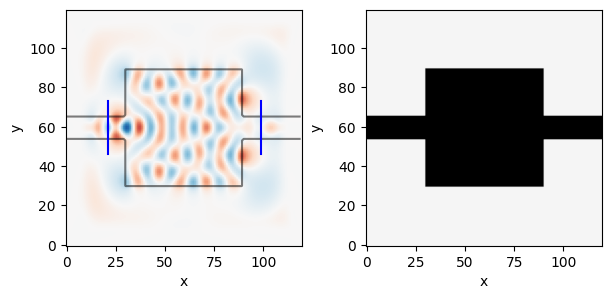

In [8]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez, probe)

## Optimization

In [9]:
from inverse_design.local_generator import dilate

In [10]:
bg_mask = np.logical_or(bg_epsr>2, design_region)
eroded = dilate(np.logical_not(bg_mask), brush)
dilated = dilate(bg_epsr>2, brush)

init_t_s = np.logical_not(np.logical_or(eroded, design_region)) 
init_t_v = np.logical_not(np.logical_or(dilated, design_region)) 
# plt.imshow(init_t_s, vmax=1, vmin=0)
# plt.figure()
# plt.imshow(init_t_v, vmax=1, vmin=0)

In [11]:
latent_t = transform(latent, brush)
generate_feasible_design_mask(
  latent_t, brush, init_touches_solid=init_t_s.copy(), 
  init_touches_void=init_t_v.copy(), verbose=False)

Array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [12]:
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, init_touches_solid=init_t_s, init_touches_void=init_t_v, verbose=False)
    epsr = (design_mask+1.0)/2.0*(12-1) +1 
    # complicated expression to avoid where clause, as it caused problems with differentiation
    # why did the np.where clause lead to 0 gradients?
    return epsr

In [13]:
@jaxit(cache=True)
def inner_loss_fn(epsr):
    #print(".")
    simulation.eps_r = mask_combine_epsr(epsr, bg_epsr, design_region)
    _, _, Ez = simulation.solve(source)

    return -mode_overlap(Ez, probe) / E0

def loss_fn(latent):
    epsr = forward(latent, brush)
    # def debug_plot(epsr):
    #   plt.figure(figsize=(0.5,0.5))
    #   plt.imshow(epsr)
    #   plt.axis("off")
    #   plt.show()
    # jax.debug.callback(debug_plot, epsr)
    return inner_loss_fn(epsr)

In [16]:
#| hide
#| eval:false
# do not evaluate to avoid problems with gh-actions
grad_fn = jax.jacfwd(generate_feasible_design_mask)
grads = grad_fn(latent_t, brush)
assert grads.std() != 0

In [17]:
#| hide
#| eval:false
grad_fn = jax.jacfwd(forward)
grads = grad_fn(latent, brush)
assert grads.std() != 0

In [18]:
loss_fn(latent)

-5726509.675788443

In [19]:
#| hide
grad_fn = jax.value_and_grad(loss_fn)
loss, grad = grad_fn(latent)
assert grad.std() != 0
assert loss != 0

In [20]:
init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(latent) #.flatten()

this is the optimization step:

In [ ]:
def step_fn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    loss, grads = grad_fn(latent)
    #loss = loss_fn(latent)
    optim_state = update_fn(step, grads, state)
    optim_latent = params_fn(optim_state)
    optim_latent = optim_latent/optim_latent.std()
    return loss, init_fn(optim_latent)

We can now loop over the optimization (let's only do 5 iterations to avoid excessive computations):

In [ ]:
Nsteps = 5

In [ ]:
#|
range_ = trange(Nsteps)
losses = np.ndarray(Nsteps)
for step in range_:
    loss, state = step_fn(step, state)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))

In [ ]:
# Simulate and show the optimal device
epsr_optimum = forward(params_fn(state), brush)
epsr_optimum_total = mask_combine_epsr(epsr_optimum, bg_epsr, design_region)
simulation, ax = viz_sim(epsr_optimum_total, source, slices=[input_slice, output_slice])

In [ ]:
plt.plot(losses)
plt.xlabel("step number")
plt.ylabel("loss")